---
title: Fantasy Basketball 9 Category Simulations 
description: An NBA API Investigation
date: 05-18-2024
author: Maxwell Patterson
categories: [Basketball]
format: 
  html:
    code-fold: false
    code-tools: true
---

![](conley.png){width=90%}

# Introduction

In this blog post, I will be exploring the NBA API and combining it with data pulled from my fantasy league. Our league is a dynasty format, where the same players are kept each season and only rookies are drafted. See *The Dynamics of Dynasty* blog post for a deep dive on the league! 

First, let's start by loading in the fantasy league data to get the fantasy team each player is on. Then this data will be merged with data from the NBA API to pull players stats from last season.

# Data Preprocessing

In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
from itertools import combinations
from IPython.display import display, HTML

from nba_api.stats.endpoints import leaguedashteamstats
from nba_api.stats.static import players, teams
from nba_api.stats.endpoints import leaguedashplayerstats

In [304]:
# Load in fantasy data
fantrax_data = pd.read_csv("fantrax_05_18_2024.csv")

# Keep only 'Player' and 'Status' columns
fantrax_data = fantrax_data[['Player', 'Status', 'FPts', 'FP/G']]

# Removing free agent players
fantrax_data = fantrax_data[fantrax_data['Status'] != 'FA']

# Updating Status column name
fantrax_data = fantrax_data.rename(columns = {'Status': 'Fantasy Team'})

# Create dictionary to redefine team names 
status_mapping = {
    'CCC': 'Cream City',
    'STARKS': 'Winterfell',
    'BBB': 'Bikini Bottom',
    'HBC': 'Helsinki',
    'Jmarr237': 'Malibu',
    'maxpat01': 'Santa Barbara',
    'GBRAYERS': 'Scottsdale',
    'BIGFOOTS': 'Beaverton',
    '$?$': 'Las Vegas',
    'SDP': 'San Diego',
    'SERP': 'Slytherin',
    'Orcas': 'Anacortes'
}

# Apply team name mapping
fantrax_data['Fantasy Team'] = fantrax_data['Fantasy Team'].map(status_mapping)

Now that the Fantrax data is cleaned, we can join it with each players stats pulled from the NBA API.

In [305]:
# Extract player names
player_names = fantrax_data['Player'].tolist()

# Get player information from NBA API
nba_players = players.get_players()

player_id_map = {player['full_name']: player['id'] for player in nba_players if player['full_name'] in player_names}

fantrax_data['Player_ID'] = fantrax_data['Player'].map(player_id_map)

player_stats = leaguedashplayerstats.LeagueDashPlayerStats(season='2023-24').get_data_frames()[0]

df = pd.merge(fantrax_data, player_stats, left_on='Player_ID', right_on='PLAYER_ID', how='left')

Let's check out the data to make sure it looks good.


In [306]:
df.columns

Index(['Player', 'Fantasy Team', 'FPts', 'FP/G', 'Player_ID', 'PLAYER_ID',
       'PLAYER_NAME', 'NICKNAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'AGE', 'GP',
       'W', 'L', 'W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV',
       'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS',
       'NBA_FANTASY_PTS', 'DD2', 'TD3', 'WNBA_FANTASY_PTS', 'GP_RANK',
       'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK',
       'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK',
       'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK', 'REB_RANK',
       'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK',
       'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK',
       'DD2_RANK', 'TD3_RANK', 'WNBA_FANTASY_PTS_RANK'],
      dtype='object')

In [307]:
df

,Player,Fantasy Team,FPts,FP/G,Player_ID,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,...,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK
0,Nikola Jokic,Cream City,5154,65.24,203999.0,203999.0,Nikola Jokic,Nikola,1.610613e+09,DEN,...,32.0,541.0,542.0,6.0,5.0,1.0,1.0,2.0,2.0,2.0
1,Luka Doncic,Winterfell,4644,66.34,1629029.0,1629029.0,Luka Doncic,Luka,1.610613e+09,DAL,...,108.0,497.0,475.0,4.0,1.0,32.0,2.0,6.0,3.0,1.0
2,Giannis Antetokounmpo,Bikini Bottom,4394,60.19,203507.0,203507.0,Giannis Antetokounmpo,Giannis,1.610613e+09,MIL,...,22.0,565.0,555.0,1.0,3.0,29.0,3.0,4.0,4.0,3.0
3,Domantas Sabonis,Bikini Bottom,4345,52.99,1627734.0,1627734.0,Domantas Sabonis,Domantas,1.610613e+09,SAC,...,64.0,561.0,571.0,12.0,26.0,130.0,5.0,1.0,1.0,5.0
4,Anthony Davis,Bikini Bottom,4338,57.08,203076.0,203076.0,Anthony Davis,Anthony,1.610613e+09,LAL,...,4.0,559.0,524.0,7.0,12.0,85.0,4.0,3.0,10.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,Steven Adams,Scottsdale,0,0.00,203500.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315,Lonzo Ball,Las Vegas,0,0.00,1628366.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
316,Kai Jones,Scottsdale,0,0.00,1630539.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
317,Christian Koloko,Cream City,0,0.00,1631132.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data has been merged successfully! Now, let's perform some data cleaning to filter out players that were not active last season.

In [308]:
df = df.dropna()

While our league is a points league, where fantasy points are the scoring metric, some leagues are set up as a 9 category format where teams try to win each week based on the 9 main statistical categories. 

The categories are:
- Points
- Rebounds
- Assists
- Steals
- Blocks
- Field goal percentage
- Free throw percentage
- Three pointers made
- Turnovers

Let's see where each fantasy teams strengths would be in this format!

In [309]:
pd.options.mode.chained_assignment = None

# Columns to be used for Z-score calculations
categories = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'FG_PCT', 'FT_PCT', 'FG3M', 'TOV']

# Calculate per-game stats for each player in each category
for category in categories:
    if category not in ['FG_PCT', 'FT_PCT']:
        df[category + '_PG'] = df[category] / df['GP']
    else:
        df[category + '_PG'] = df[category]  # Percentages are already per-game

# Calculate Z-scores for each player in each per-game category
for category in categories:
    if category not in ['FG_PCT', 'FT_PCT']:
        z_score_column = category + '_PG_Z'
        df[z_score_column] = (df[category + '_PG'] - df[category + '_PG'].mean()) / df[category + '_PG'].std()
    else:
        z_score_column = category + '_Z'
        df[z_score_column] = (df[category] - df[category].mean()) / df[category].std()

# Aggregate the Z-scores by team
team_z_scores = df.groupby('Fantasy Team')[[col for col in df.columns if col.endswith('_Z')]].mean()

# Display the Z-scores table in HTML format
display(HTML(team_z_scores.to_html(float_format="%.2f", border=0, justify='center')))

,PTS_PG_Z,REB_PG_Z,AST_PG_Z,STL_PG_Z,BLK_PG_Z,FG_PCT_Z,FT_PCT_Z,FG3M_PG_Z,TOV_PG_Z
Fantasy Team,,,,,,,,,
Anacortes,-0.13,-0.17,-0.12,0.00,-0.08,0.07,-0.36,-0.23,-0.02
Beaverton,0.09,-0.36,-0.03,-0.04,-0.41,-0.33,0.26,0.49,0.07
Bikini Bottom,0.35,0.45,0.38,0.13,0.24,0.28,0.23,-0.05,0.33
Cream City,0.08,0.30,-0.05,0.16,0.34,0.29,0.27,0.19,-0.10
Helsinki,-0.09,-0.19,-0.12,-0.19,-0.05,0.09,-0.24,-0.19,-0.22
Las Vegas,-0.22,-0.06,-0.39,-0.00,-0.04,-0.21,-0.20,-0.09,-0.21
Malibu,0.32,0.31,0.37,0.30,0.26,0.07,0.25,0.28,0.28
San Diego,0.16,-0.05,0.06,0.30,-0.03,0.06,0.20,0.20,0.18
Santa Barbara,-0.30,-0.31,-0.28,-0.16,-0.02,-0.02,-0.24,-0.02,-0.15


This table shows us which teams are strongest in each categories. As we saw in the previous post, BBB (Bikini Bottom Ballers) are by far the strongest team. JMarr237 (Malibu Mamas) also has a deep roster with lots of good players. 

# Monte Carlo Simulation

When it comes to predicting the outcome of a fantasy basketball season, there are many factors to consider. Each team's performance can vary from week to week based on the number of games their players have, potential injuries, and the inherent randomness of sports. This is where Monte Carlo simulations come in handy.

Monte Carlo simulations are a powerful tool that allows us to model complex systems and account for randomness. In the context of our fantasy basketball league, we can use these simulations to generate many possible outcomes for the season, taking into account the variability in each team's performance.

Think of it like a game of tug-of-war. Each team's Z score represents their baseline strength in a particular category. The higher the Z score, the stronger the team is in that category. However, just like in a real game of tug-of-war, there are external factors that can influence the outcome, such as the condition of the rope, the terrain, or even a momentary lapse in concentration from one of the participants. In our simulation, we'll be using three levels of randomness: low, medium, and high. These levels represent how much each team's performance can deviate from their expected Z scores each week. A low level of randomness means that the results will be closer to what we expect based on the Z scores, while a high level of randomness introduces more unpredictability.

By running the simulation 250 times, we can generate a wide range of plausible scenarios. Each simulation will give us a different set of results, and by analyzing these results, we can gain insights into the likelihood of various outcomes.

For example, let's say Team A has a higher Z score than Team B in the "points" category. In a single simulation, Team B might win that category due to the randomness factor. However, across 250 simulations, we would expect Team A to win the "points" category more often than Team B.

Monte Carlo simulations help us account for the complexities and uncertainties in a fantasy basketball season. By embracing randomness and running many simulations, we can better understand the range of possible outcomes and make more informed decisions when managing our fantasy teams.

In [310]:
team_z_scores = team_z_scores.reset_index()

 # Parameters
teams = team_z_scores['Fantasy Team'].unique()
randomness_levels = {'low': 0.3, 'medium': 0.6, 'high': 0.9}
num_weeks = 22
num_simulations = 250

In [311]:
# Initialize results df to track wins, losses, and ties
results_template = pd.DataFrame(0, index=teams, columns=['Wins', 'Losses'])

In [312]:
def simulate_season(randomness):
    weekly_results = results_template.copy()

    # Create a schedule where each team plays every other team twice
    matchups = list(combinations(teams, 2)) * 2
    random.shuffle(matchups)  # Randomize the order of matchups

    # Distribute matchups across 22 weeks
    weeks = [matchups[i:i + len(teams)//2] for i in range(0, len(matchups), len(teams)//2)]

    for week in weeks:
        for team1, team2 in week:
            team1_score = 0
            team2_score = 0

            for category in categories:
                z_score_column = category + '_PG_Z' if category not in ['FG_PCT', 'FT_PCT'] else category + '_Z'
                team1_z = team_z_scores.loc[team_z_scores['Fantasy Team'] == team1, z_score_column].values[0]
                team2_z = team_z_scores.loc[team_z_scores['Fantasy Team'] == team2, z_score_column].values[0]

                team1_z += np.random.normal(0, randomness * abs(team1_z))
                team2_z += np.random.normal(0, randomness * abs(team2_z))

                if category == 'TOV':
                    if team1_z < team2_z:  # Fewer turnovers is better
                        team1_score += 1
                    else:
                        team2_score += 1
                else:
                    if team1_z > team2_z:  # More is better for other categories
                        team1_score += 1
                    else:
                        team2_score += 1

            if team1_score > team2_score:
                weekly_results.at[team1, 'Wins'] += 1
                weekly_results.at[team2, 'Losses'] += 1
            elif team1_score < team2_score:
                weekly_results.at[team1, 'Losses'] += 1
                weekly_results.at[team2, 'Wins'] += 1

    return weekly_results

In [313]:
def simulate_multiple_seasons(randomness, num_simulations):
    cumulative_results = pd.DataFrame(0, index=teams, columns=['Wins', 'Losses'])
    all_simulation_results = []

    for _ in range(num_simulations):
        season_results = simulate_season(randomness)
        cumulative_results += season_results
        all_simulation_results.append(season_results['Wins'].copy())

    # Calculate average results
    average_results = cumulative_results / num_simulations
    return average_results, pd.concat(all_simulation_results, axis=1)

Now that the Monte Carlo simulation functions have been set up, we can run the simulation 250 times.

In [314]:
# Perform the simulations
final_results = {}
simulation_results = {}

for level, randomness in randomness_levels.items():
    avg_results, all_results_df = simulate_multiple_seasons(randomness, num_simulations)
    final_results[level] = avg_results
    simulation_results[level] = all_results_df

In [317]:
# Combine results ensuring unique column names
results_table = pd.concat(final_results, axis=1, keys=randomness_levels.keys())
results_table.columns = [f'{level.capitalize()} {col}' for level, col in results_table.columns]

# Sort the table by 'Low Randomness' wins in descending order
results_table_sorted = results_table.sort_values(by='Low Wins', ascending=False)

display(HTML(results_table_sorted.to_html(float_format="%.2f", border=0, justify='center')))

,Low Wins,Low Losses,Medium Wins,Medium Losses,High Wins,High Losses
Malibu,20.58,1.42,20.14,1.86,19.71,2.29
Cream City,19.76,2.24,19.62,2.38,19.25,2.75
Bikini Bottom,19.30,2.70,19.12,2.88,18.68,3.32
San Diego,15.72,6.28,16.07,5.93,15.97,6.03
Winterfell,14.64,7.36,14.84,7.16,14.82,7.18
Las Vegas,8.23,13.77,6.65,15.35,6.04,15.96
Anacortes,7.68,14.32,6.80,15.20,6.54,15.46
Scottsdale,7.54,14.46,7.58,14.42,7.70,14.30
Helsinki,7.39,14.61,6.80,15.20,6.80,15.20
Beaverton,6.89,15.11,7.73,14.27,8.00,14.00


Reminder that this is for a 22 week regular season where each team plays each other twice. Under a 9-cat format, the Bikini Bottom Ballers are still the best team in the league. SDP, the San Diego Pilots, would seem to fare much better in a 9-cat format than the current points format.

# Plotting Team Outcomes

Now let's visualize the results by showing the win distribution for each team under each randomness scenario.

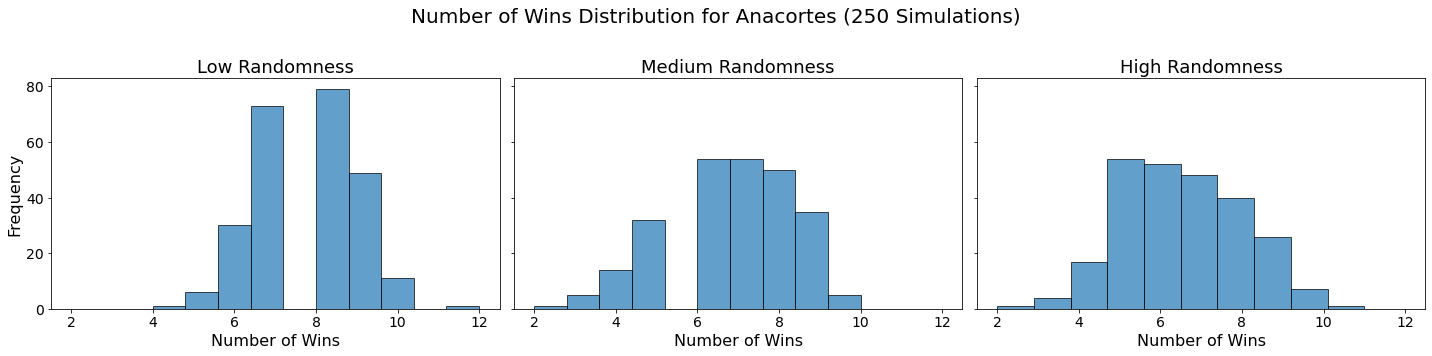

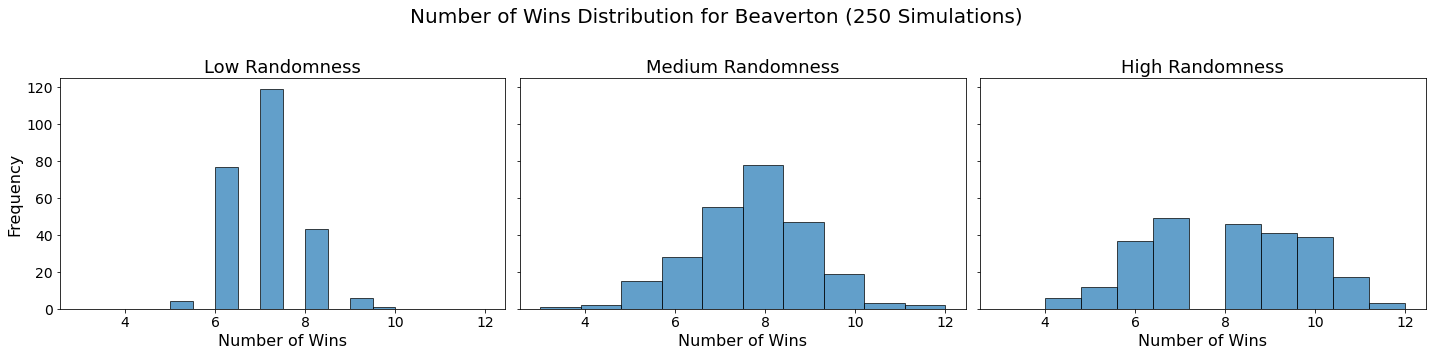

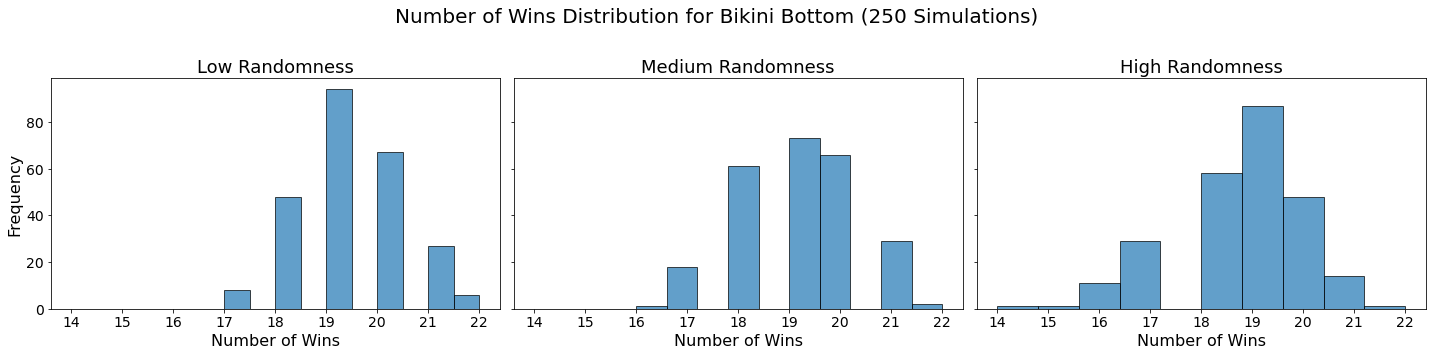

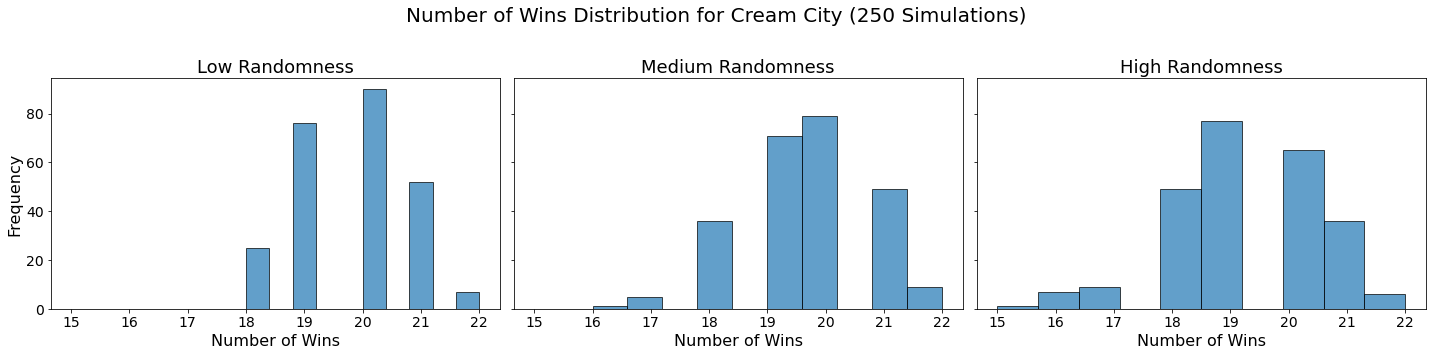

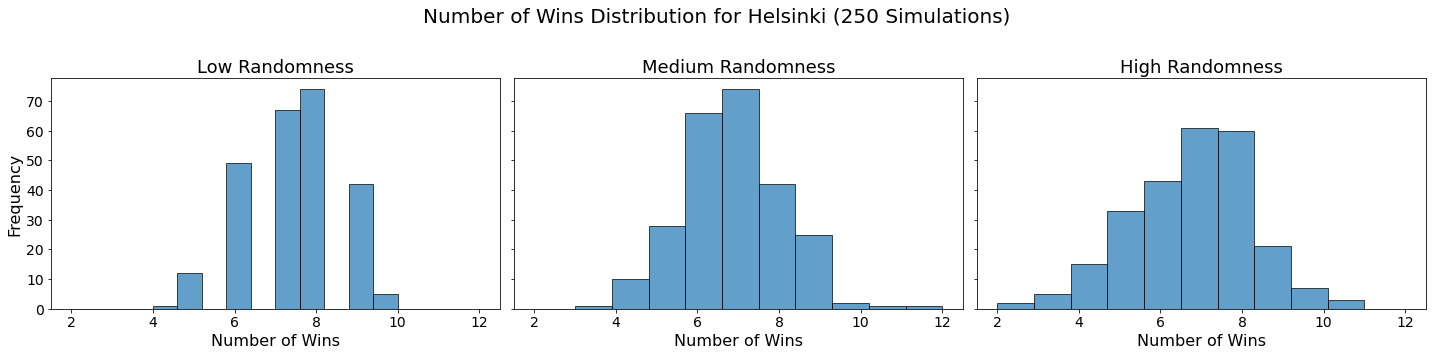

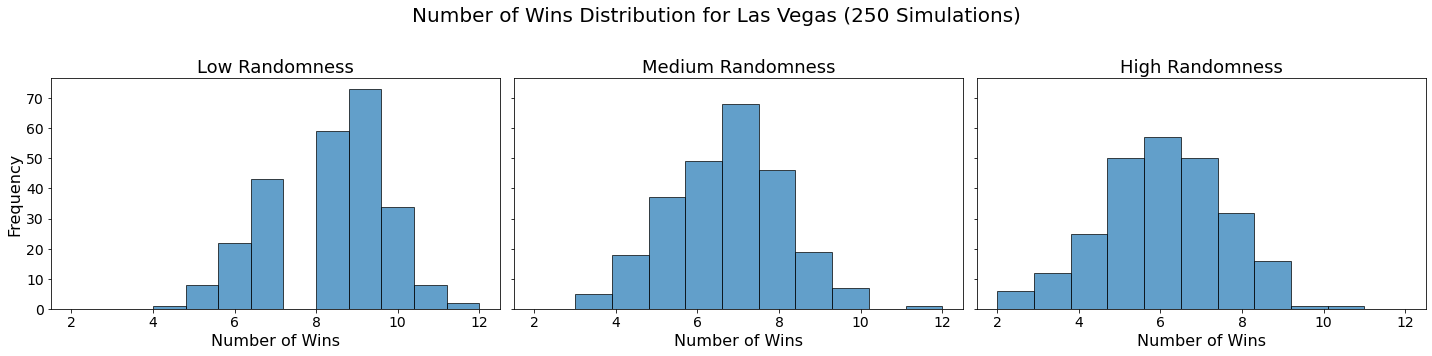

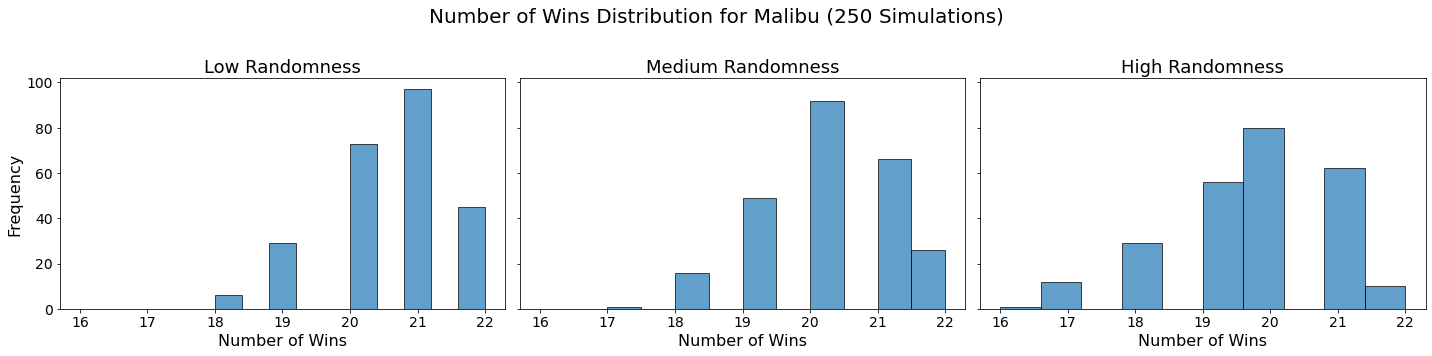

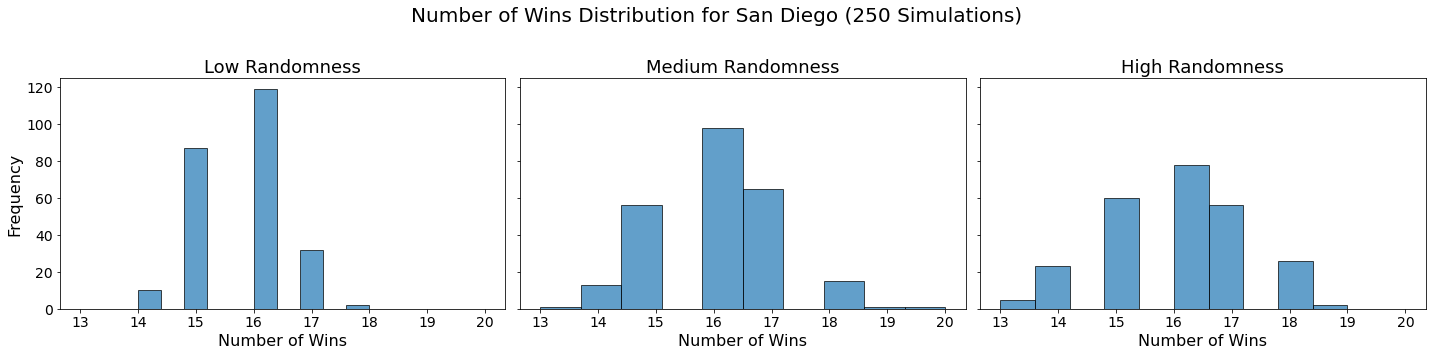

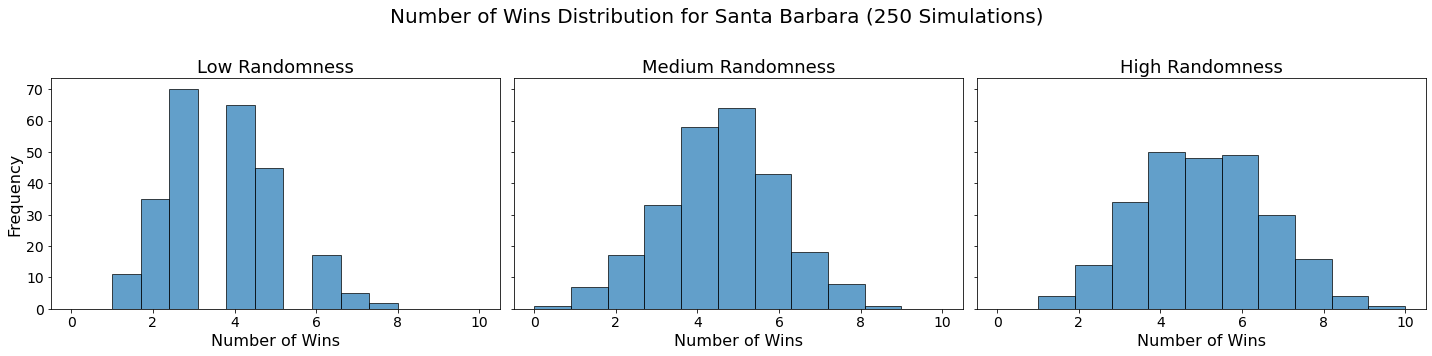

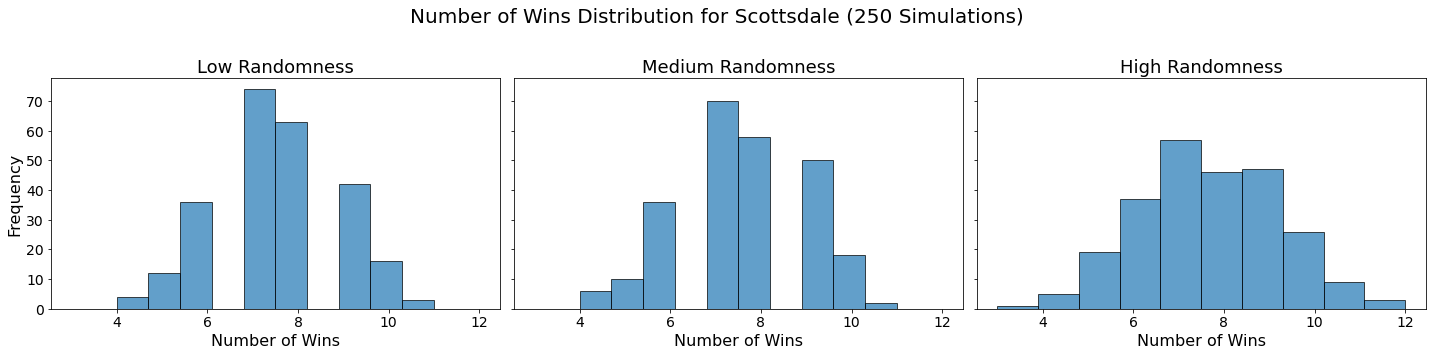

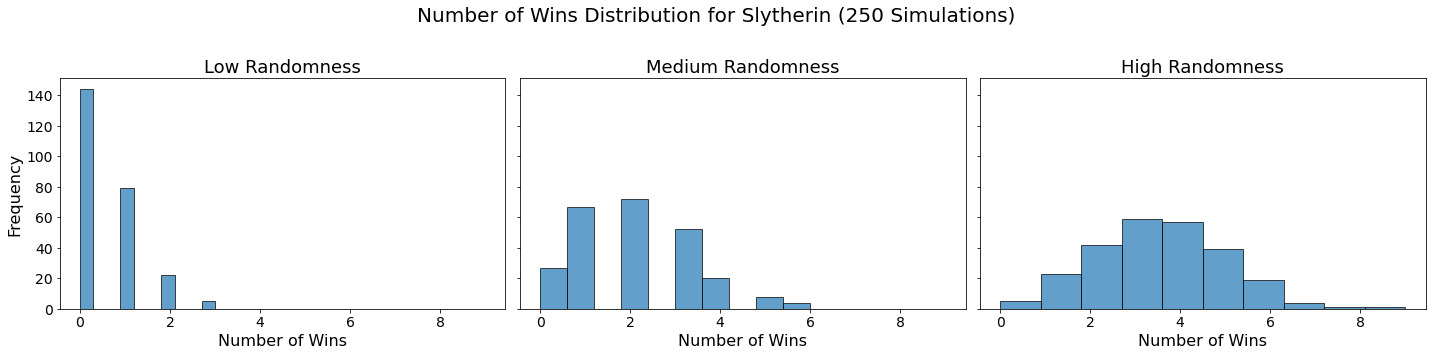

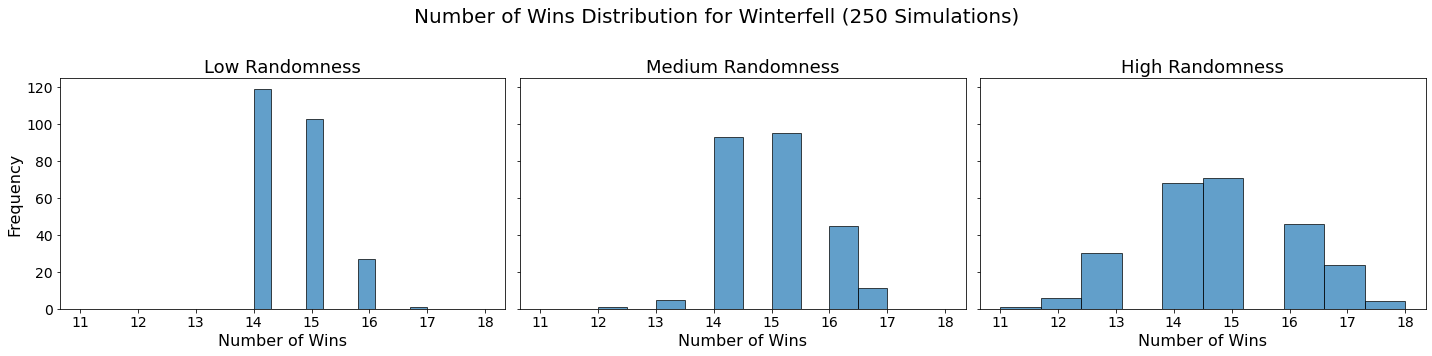

In [318]:
for team in teams:
    fig, axes = plt.subplots(1, len(randomness_levels), figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle(f'Number of Wins Distribution for {team} (250 Simulations)', fontsize=20)

    for col, (level, results_df) in enumerate(simulation_results.items()):
        axes[col].hist(results_df.loc[team], bins=10, alpha=0.7, edgecolor='black')
        axes[col].set_title(f'{level.capitalize()} Randomness', fontsize=18)
        axes[col].set_xlabel('Number of Wins', fontsize=16)
        axes[col].tick_params(axis='both', which='major', labelsize=14)
        if col == 0:
            axes[col].set_ylabel('Frequency', fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Conclusion

In our analysis, we utilized Monte Carlo simulations to project the outcomes of a fantasy basketball season under different levels of randomness. By running 250 simulations for each level of randomness — low, medium, and high — we were able to model the inherent variability in team performances. This approach not only allowed us to see which teams are likely to excel consistently but also highlighted how randomness can impact the overall season. The histograms generated for each team showed the distribution of their wins across simulations, providing a visual representation of their performance stability.

# Bonus: Points Analysis

I've also created the same workflow, but for points instead of 9-CAT since this the scoring of my fintasy league

,low Wins,low Losses,medium Wins,medium Losses,high Wins,high Losses
Bikini Bottom,18.10,3.90,15.02,6.98,13.90,8.10
Malibu,16.67,5.33,14.16,7.84,13.35,8.65
Winterfell,15.15,6.85,13.38,8.62,12.40,9.60
Cream City,14.42,7.58,13.13,8.87,12.38,9.62
San Diego,12.21,9.79,11.46,10.54,11.46,10.54
Scottsdale,9.93,12.07,10.60,11.40,10.51,11.49
Anacortes,8.90,13.10,9.25,12.75,10.14,11.86
Beaverton,8.85,13.15,9.71,12.29,10.39,11.61
Helsinki,8.44,13.56,9.66,12.34,9.89,12.11
Slytherin,6.58,15.42,8.74,13.26,9.25,12.75


,low Wins Win %,low Losses Win %,medium Wins Win %,medium Losses Win %,high Wins Win %,high Losses Win %
Bikini Bottom,82.29,17.71,68.25,31.75,63.18,36.82
Malibu,75.78,24.22,64.35,35.65,60.67,39.33
Winterfell,68.85,31.15,60.80,39.20,56.38,43.62
Cream City,65.56,34.44,59.69,40.31,56.29,43.71
San Diego,55.49,44.51,52.09,47.91,52.11,47.89
Scottsdale,45.15,54.85,48.18,51.82,47.78,52.22
Anacortes,40.44,59.56,42.04,57.96,46.09,53.91
Beaverton,40.22,59.78,44.15,55.85,47.24,52.76
Helsinki,38.35,61.65,43.93,56.07,44.96,55.04
Slytherin,29.93,70.07,39.73,60.27,42.05,57.95


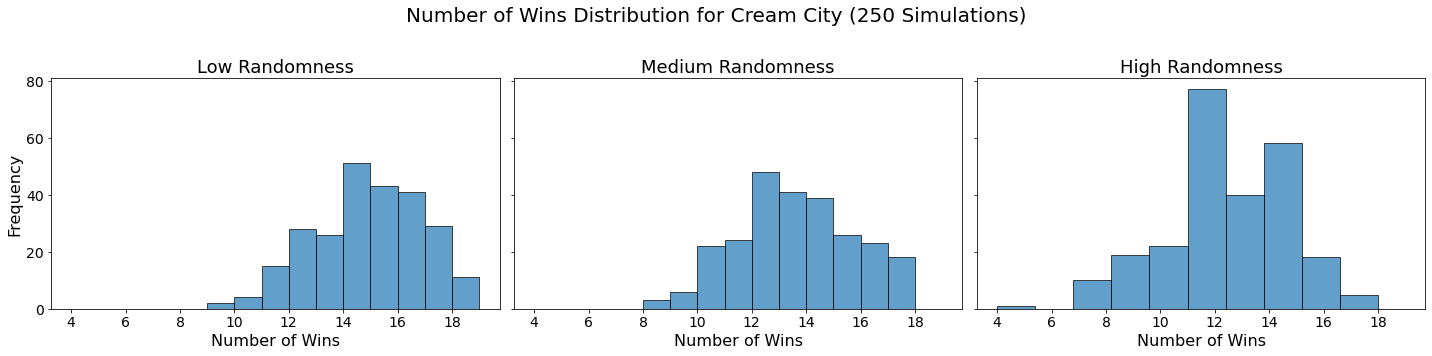

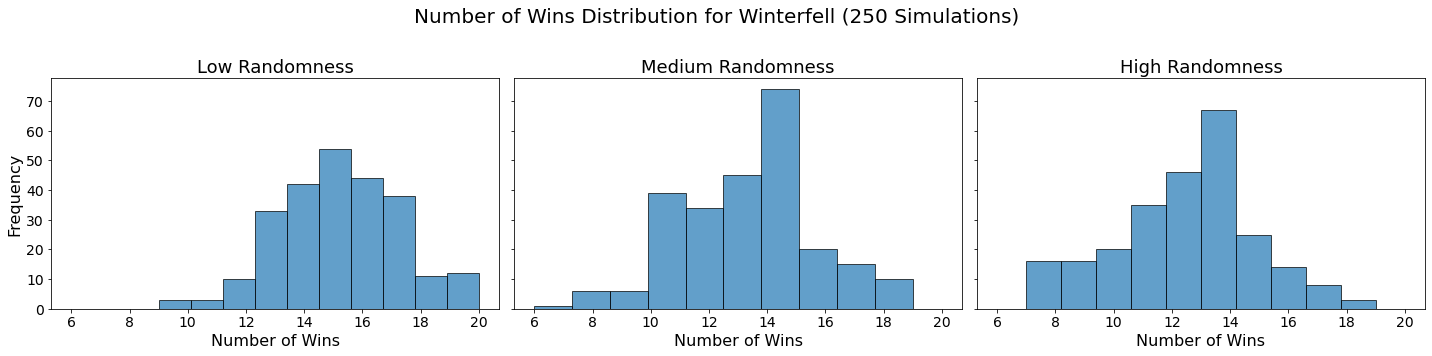

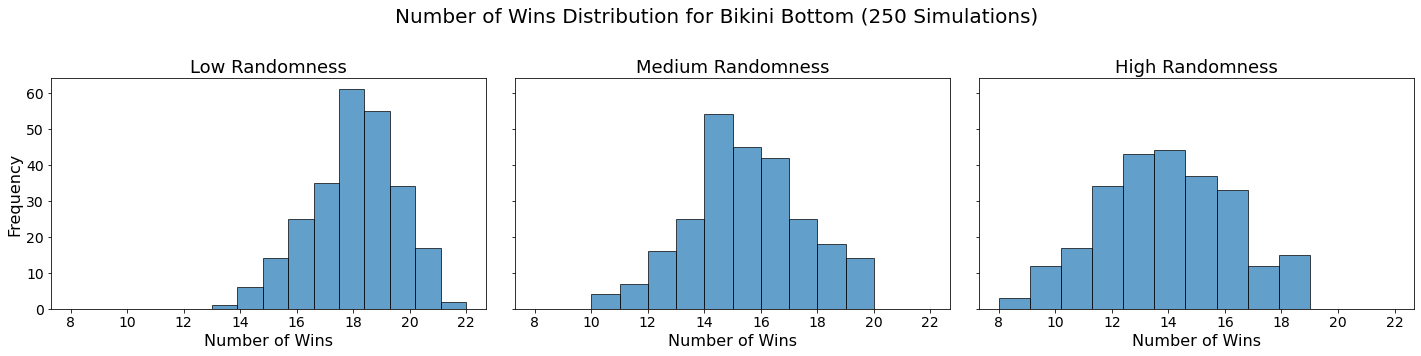

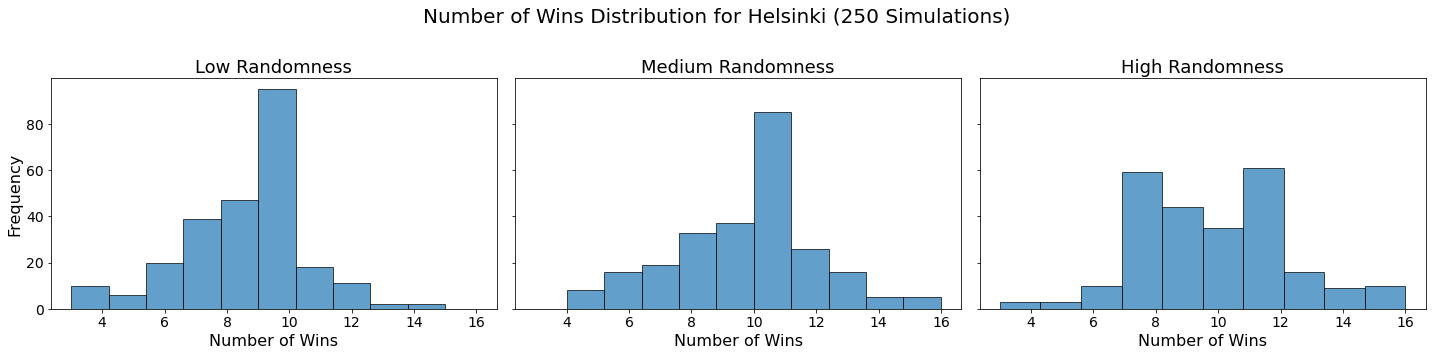

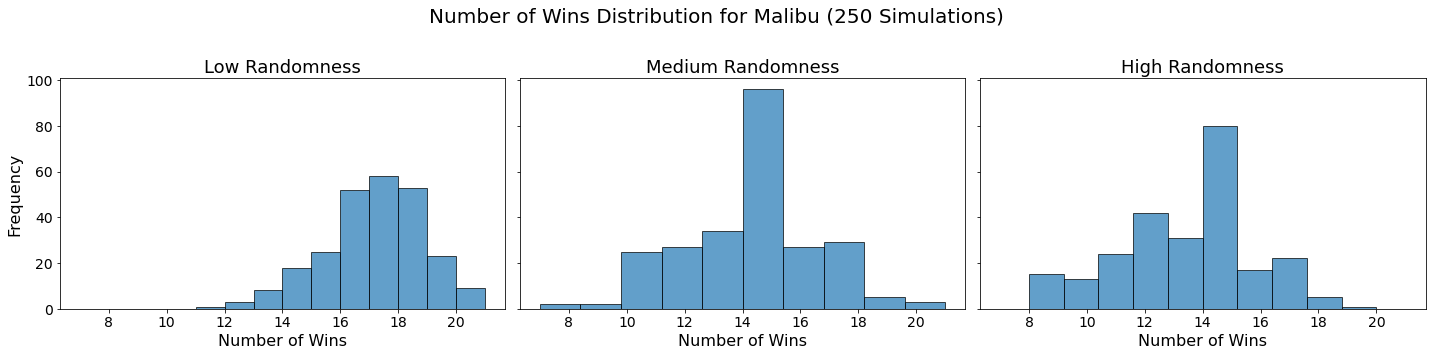

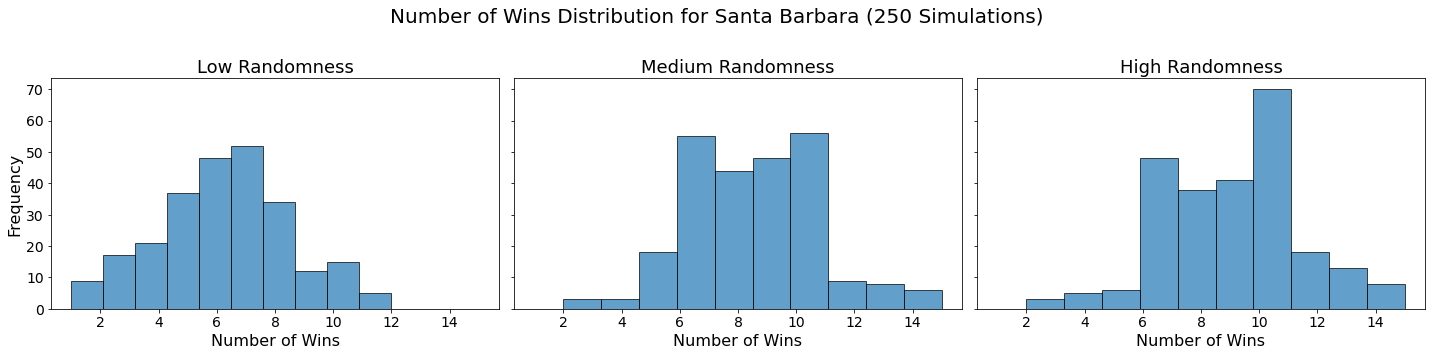

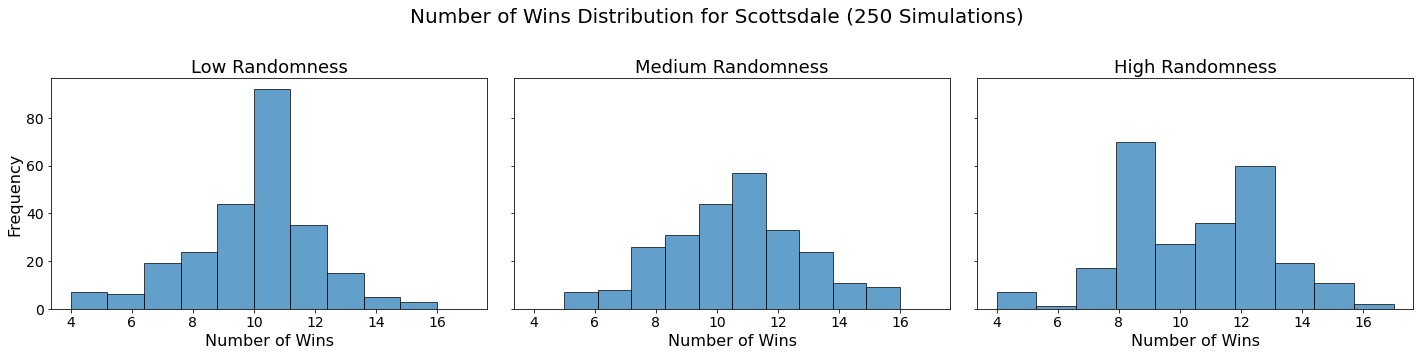

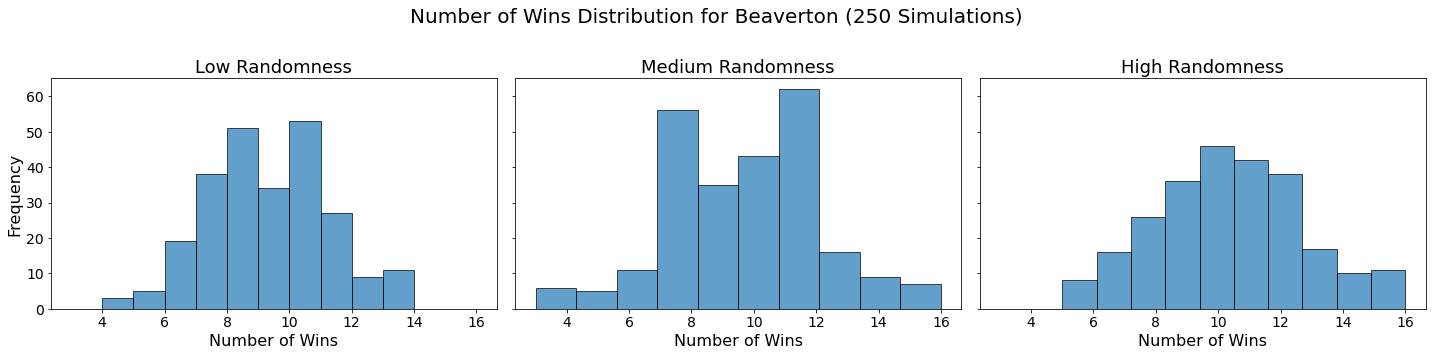

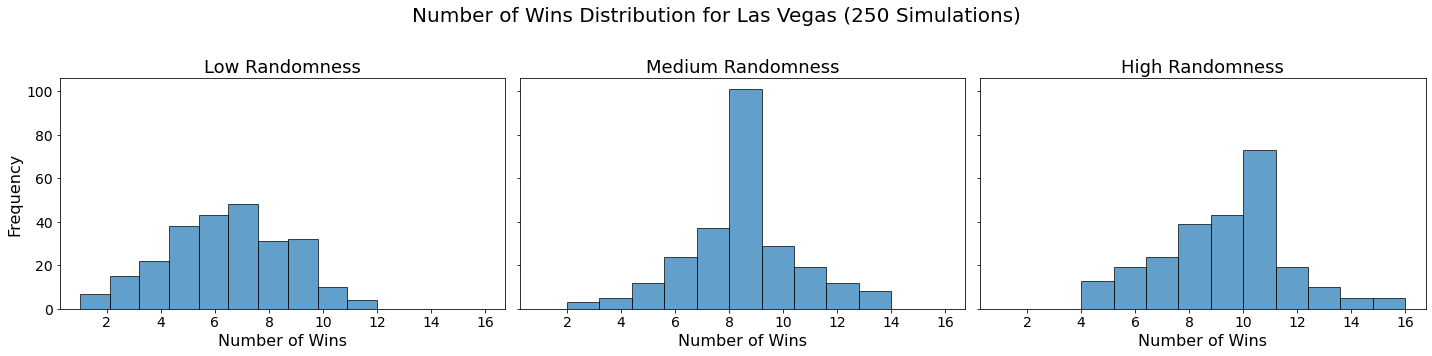

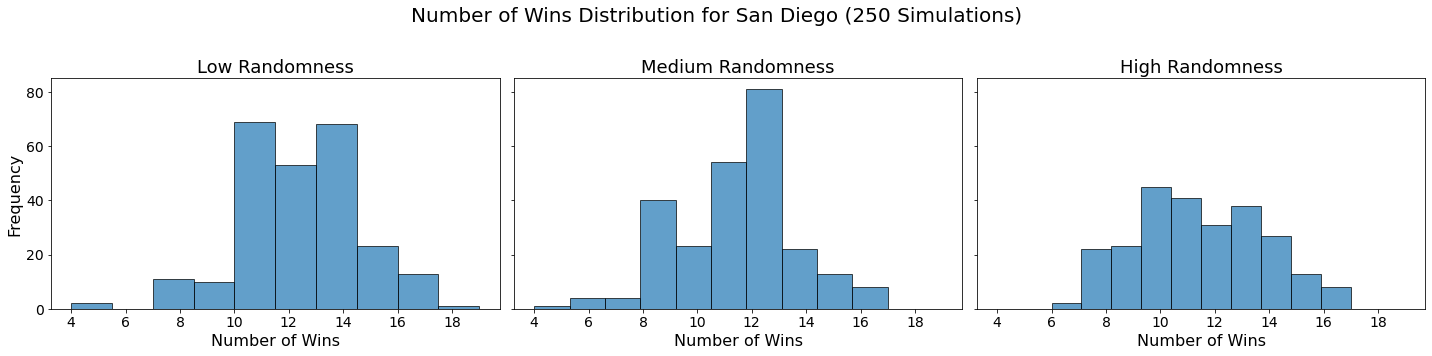

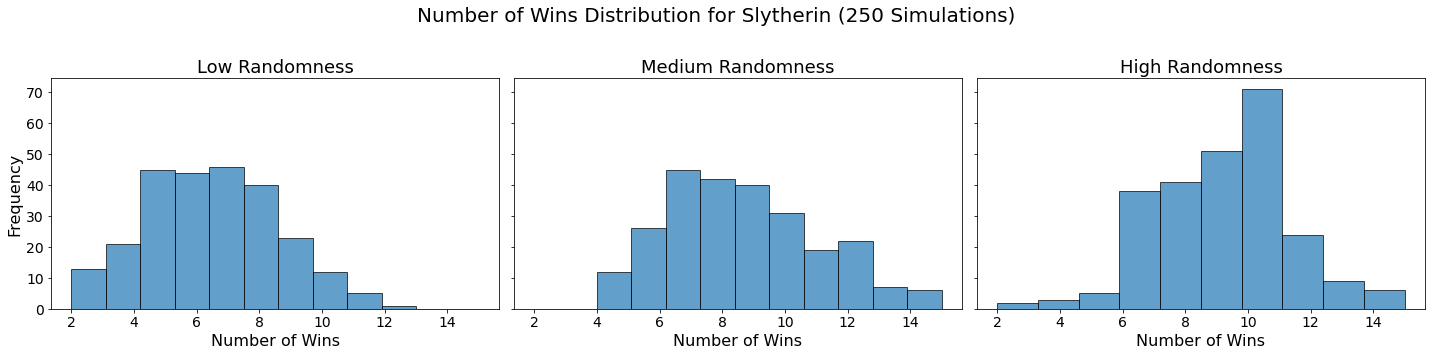

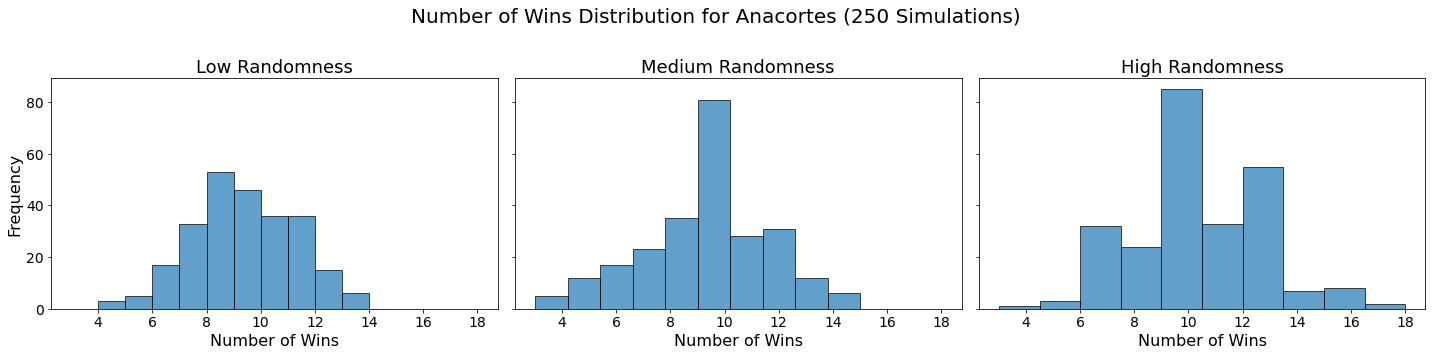

In [323]:
pd.options.mode.chained_assignment = None

# Calculate "percent started" based on player ranking within each fantasy team
df['Rank'] = df.groupby('Fantasy Team')['FP/G'].rank(ascending=False)
df['Percent Started'] = df['Rank'].apply(lambda x: 1 if x <= 10 else 0.8 if x <= 15 else 0.4)

# Parameters
teams = df['Fantasy Team'].unique()
randomness_levels = {'low': 0.2, 'medium': 0.4, 'high': 0.6}
num_weeks = 22
num_simulations = 250

# Initialize results df to track wins and losses
results_template = pd.DataFrame(0, index=teams, columns=['Wins', 'Losses'])

def simulate_season_fp(randomness):
    weekly_results = results_template.copy()

    # Create a schedule where each team plays every other team twice
    matchups = list(combinations(teams, 2)) * 2
    random.shuffle(matchups)  # Randomize the order of matchups

    # Distribute matchups across 22 weeks
    weeks = [matchups[i:i + len(teams)//2] for i in range(0, len(matchups), len(teams)//2)]

    for week in weeks:
        for team1, team2 in week:
            team1_players = df[df['Fantasy Team'] == team1]
            team2_players = df[df['Fantasy Team'] == team2]

            team1_fp = (team1_players['FP/G'] * team1_players['Percent Started']).sum()
            team2_fp = (team2_players['FP/G'] * team2_players['Percent Started']).sum()

            team1_fp += np.random.normal(0, randomness * abs(team1_fp))
            team2_fp += np.random.normal(0, randomness * abs(team2_fp))

            if team1_fp > team2_fp:
                weekly_results.at[team1, 'Wins'] += 1
                weekly_results.at[team2, 'Losses'] += 1
            elif team1_fp < team2_fp:
                weekly_results.at[team1, 'Losses'] += 1
                weekly_results.at[team2, 'Wins'] += 1

    return weekly_results

def simulate_multiple_seasons_fp(randomness, num_simulations):
    cumulative_results = pd.DataFrame(0, index=teams, columns=['Wins', 'Losses'])
    all_simulation_results = []

    for _ in range(num_simulations):
        season_results = simulate_season_fp(randomness)
        cumulative_results += season_results
        all_simulation_results.append(season_results['Wins'].copy())

    # Calculate average results
    average_results = cumulative_results / num_simulations
    return average_results, pd.concat(all_simulation_results, axis=1)

# Perform the simulations
final_results_fp = {}
simulation_results_fp = {}

for level, randomness in randomness_levels.items():
    avg_results_fp, all_results_df_fp = simulate_multiple_seasons_fp(randomness, num_simulations)
    final_results_fp[level] = avg_results_fp
    simulation_results_fp[level] = all_results_df_fp

# Combine results ensuring unique column names
results_table_fp = pd.concat(final_results_fp, axis=1, keys=randomness_levels.keys())
results_table_fp.columns = [' '.join(col).strip() for col in results_table_fp.columns.values]

# Sort the table by 'low Wins' in descending order
results_table_sorted_fp = results_table_fp.sort_values(by='low Wins', ascending=False)

display(HTML(results_table_sorted_fp.to_html(float_format="%.2f", border=0, justify='center')))

# Calculate win percentages (number of wins divided by 22)
win_percentages_fp = results_table_sorted_fp / num_weeks * 100
win_percentages_fp.columns = [f'{col} Win %' for col in win_percentages_fp.columns]

# Display the win percentage table
display(HTML(win_percentages_fp.to_html(float_format="%.2f", border=0, justify='center')))

# Plot histograms for the number of wins for each team in each simulation for each level of randomness
for team in teams:
    fig, axes = plt.subplots(1, len(randomness_levels), figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle(f'Number of Wins Distribution for {team} (250 Simulations)', fontsize=20)

    for col, (level, results_df_fp) in enumerate(simulation_results_fp.items()):
        axes[col].hist(results_df_fp.loc[team], bins=10, alpha=0.7, edgecolor='black')
        axes[col].set_title(f'{level.capitalize()} Randomness', fontsize=18)
        axes[col].set_xlabel('Number of Wins', fontsize=16)
        axes[col].tick_params(axis='both', which='major', labelsize=14)
        if col == 0:
            axes[col].set_ylabel('Frequency', fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()